In [1]:
from numpy.random import seed
seed(7532)
from tensorflow import set_random_seed
set_random_seed(7532)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import (BatchNormalization, Dense, Dropout, Conv2D, Flatten, MaxPool2D)
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

Using TensorFlow backend.


Read in the data.

In [2]:
train_set = pd.read_csv('train_set_metadata.csv')
valid_set = pd.read_csv('valid_set_metadata.csv')
test_set = pd.read_csv('test_set_metadata.csv')

train_set_partition = np.load('train_set_partition.npy')

Compute the number of parts the train set was partitioned into.

In [3]:
n_parts = len(train_set_partition) - 1
n_parts

20

**CNN Model Training with VGG19**

In [4]:
BEST_MODEL_PATH = 'best_model.hdf5'
INPUT_SHAPE = (320, 320, 3)

LEARNING_RATE = 0.00001
N_EPOCHS = 200
BATCH_SIZE = 32

VGG19_CONVERSION_REQUIRED = False

In [5]:
if VGG19_CONVERSION_REQUIRED:  
    for part in range(n_parts):      
        print(f'Part {part + 1}:')

        train_filename_in = 'train_set_hmgd_arr_' + str(part + 1).zfill(2) + '.npy' 
        X_train = np.load(train_filename_in)

        train_filename_out = 'train_set_hmgd_arr_VGG19_' + str(part + 1).zfill(2) + '.npy'
        np.save(train_filename_out, preprocess_input(255 * X_train))

        del X_train

Part 1:
Part 2:
Part 3:
Part 4:
Part 5:
Part 6:
Part 7:
Part 8:
Part 9:
Part 10:
Part 11:
Part 12:
Part 13:
Part 14:
Part 15:
Part 16:
Part 17:
Part 18:
Part 19:
Part 20:


In [6]:
if VGG19_CONVERSION_REQUIRED:    
    filename_in = 'test_set_hmgd_arr.npy' 
    X_test = np.load(filename_in)

    filename_out = 'test_set_hmgd_arr_VGG19.npy'
    np.save(filename_out, preprocess_input(255 * X_test))

    del X_test

In [7]:
if VGG19_CONVERSION_REQUIRED:
    filename_in = 'valid_set_hmgd_arr.npy' 
    X_valid = np.load(filename_in)

    filename_out = 'valid_set_hmgd_arr_VGG19.npy'
    np.save(filename_out, preprocess_input(255 * X_valid))

    del X_valid

In [5]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

Freeze the convolutional layers, create the model top and attach it to the VGG19.

In [6]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [7]:
def create_model_top(input_shape):
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    #model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    
    return model

In [8]:
model_top = create_model_top(vgg19_model.outputs[0].get_shape().as_list()[1:])
model = Model(inputs=vgg19_model.inputs, outputs=model_top(vgg19_model.outputs[0]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

Verify that the appropriate layers are/are not trainable.

In [9]:
for layer in model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


Train the model on part 1 to adjust the weights of the model top.

In [ ]:
age_column_position = train_set.columns.get_loc('age')

X_valid = np.load('valid_set_hmgd_arr_VGG19.npy')
y_valid = valid_set['age'].values

batch_limit = train_set_partition[1:] - train_set_partition[:-1]
    
print('Part 1:')
    
train_filename = 'train_set_hmgd_arr_VGG19_' + str(1).zfill(2) + '.npy'
subrange = range(train_set_partition[0], train_set_partition[1])    
X_train = np.load(train_filename)
y_train = train_set.iloc[subrange, age_column_position].values


# Compile model
adam = Adam(lr=LEARNING_RATE)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Initialize callbacks
checkpoint = ModelCheckpoint(BEST_MODEL_PATH, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=False)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.2, 
                                 patience=5)        

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=11)            

callback_list = [checkpoint, 
                 lr_reduction, 
                 early_stopping]


data_gen = ImageDataGenerator(rotation_range=20, 
                              width_shift_range=0.2, 
                              height_shift_range=0.2, 
                              horizontal_flip=True)

steps_per_epoch = int(batch_limit[0] / BATCH_SIZE)

model.fit_generator(data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=N_EPOCHS,
                    callbacks=callback_list, 
                    validation_data=(X_valid, y_valid), 
                    workers=4)


#free up memory
del X_train

Part 1:
Epoch 1/200
258/258 [==============================] - 303s 1s/step - loss: 201.6866 - mean_absolute_error: 10.8573 - val_loss: 179.9706 - val_mean_absolute_error: 10.6987
Epoch 2/200
258/258 [==============================] - 275s 1s/step - loss: 129.0799 - mean_absolute_error: 8.9699 - val_loss: 171.5680 - val_mean_absolute_error: 10.5269
Epoch 3/200
258/258 [==============================] - 272s 1s/step - loss: 126.6010 - mean_absolute_error: 8.9177 - val_loss: 166.1008 - val_mean_absolute_error: 10.2764
Epoch 4/200
258/258 [==============================] - 272s 1s/step - loss: 122.3833 - mean_absolute_error: 8.7226 - val_loss: 161.7151 - val_mean_absolute_error: 10.0698
Epoch 5/200
258/258 [==============================] - 272s 1s/step - loss: 116.5404 - mean_absolute_error: 8.5299 - val_loss: 165.4893 - val_mean_absolute_error: 10.3547
Epoch 6/200
258/258 [==============================] - 272s 1s/step - loss: 112.5934 - mean_absolute_error: 8.3923 - val_loss: 164.9658 

Unfreeze the top convolutional layers of VGG19.

In [5]:
model = load_model(BEST_MODEL_PATH)

for layer in model.layers[-11:]:
    layer.trainable = True

for layer in model.layers:
    print(layer.trainable)

# compile model
adam = Adam(lr=LEARNING_RATE)
model.compile(optimizer=adam, 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])    

model.summary()

False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_______________

Since our data is divided into 20 parts the network training is performed one part at a time.

Unfortunately, a technical error is causing the training to be stopped after each and every part. Howerver, the trained model does not seem to be affected.

In [ ]:
age_column_position = train_set.columns.get_loc('age')

X_valid = np.load('valid_set_hmgd_arr_VGG19.npy')
y_valid = valid_set['age'].values

batch_limit = train_set_partition[1:] - train_set_partition[:-1]

for part in range(n_parts):        
#    if part < 2:
#        continue
        
    print(f'Part {part + 1}:')
    
    train_filename = 'train_set_hmgd_arr_VGG19_' + str(part + 1).zfill(2) + '.npy'
    subrange = range(train_set_partition[part], train_set_partition[part + 1])    
    X_train = np.load(train_filename)
    y_train = train_set.iloc[subrange, age_column_position].values
       
    # Initialize callbacks
    checkpoint = ModelCheckpoint(BEST_MODEL_PATH, 
                                 monitor='val_loss', 
                                 save_best_only=True, 
                                 save_weights_only=False)

    lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                     factor=0.2, 
                                     patience=5)        

    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=11)            

    callback_list = [checkpoint, 
                     lr_reduction, 
                     early_stopping]

    
    data_gen = ImageDataGenerator(rotation_range=20, 
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  horizontal_flip=True)
    
    steps_per_epoch = int(batch_limit[part] / BATCH_SIZE)
    
    model.fit_generator(data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=N_EPOCHS,
                        callbacks=callback_list, 
                        validation_data=(X_valid, y_valid), 
                        workers=4)
    
    
    #free up memory
    del X_train
    
    print(f'Training on part {part + 1} has been completed.\n')

Part 1:
Epoch 1/200
258/258 [==============================] - 390s 2s/step - loss: 98.0421 - mean_absolute_error: 7.7708 - val_loss: 146.3011 - val_mean_absolute_error: 9.6510
Epoch 2/200
258/258 [==============================] - 360s 1s/step - loss: 82.4996 - mean_absolute_error: 7.1100 - val_loss: 125.9610 - val_mean_absolute_error: 8.7030
Epoch 3/200
258/258 [==============================] - 356s 1s/step - loss: 77.0432 - mean_absolute_error: 6.8397 - val_loss: 126.4705 - val_mean_absolute_error: 8.7623
Epoch 4/200
258/258 [==============================] - 356s 1s/step - loss: 71.9841 - mean_absolute_error: 6.5977 - val_loss: 121.9718 - val_mean_absolute_error: 8.4419
Epoch 5/200
258/258 [==============================] - 356s 1s/step - loss: 67.5354 - mean_absolute_error: 6.3927 - val_loss: 124.3526 - val_mean_absolute_error: 8.6400
Epoch 6/200
258/258 [==============================] - 356s 1s/step - loss: 63.6109 - mean_absolute_error: 6.1716 - val_loss: 119.3405 - val_mean_a

As we no longer need to unfreze any layers, we can use the code below to finish the training on the training data.

In [5]:
model = load_model(BEST_MODEL_PATH)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

In [7]:
age_column_position = train_set.columns.get_loc('age')

X_valid = np.load('valid_set_hmgd_arr_VGG19.npy')
y_valid = valid_set['age'].values

batch_limit = train_set_partition[1:] - train_set_partition[:-1]

for part in range(n_parts):        
    if part < 19:
        continue
        
    print(f'Part {part + 1}:')
    
    train_filename = 'train_set_hmgd_arr_VGG19_' + str(part + 1).zfill(2) + '.npy'
    subrange = range(train_set_partition[part], train_set_partition[part + 1])    
    X_train = np.load(train_filename)
    y_train = train_set.iloc[subrange, age_column_position].values
    

    # Initialize callbacks
    checkpoint = ModelCheckpoint(BEST_MODEL_PATH, 
                                 monitor='val_loss', 
                                 save_best_only=True, 
                                 save_weights_only=False)

    lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                     factor=0.2, 
                                     patience=5)        

    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=11)            

    callback_list = [checkpoint, 
                     lr_reduction, 
                     early_stopping]

    
    data_gen = ImageDataGenerator(rotation_range=20, 
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  horizontal_flip=True)
    
    steps_per_epoch = int(batch_limit[part] / BATCH_SIZE)
    
    model.fit_generator(data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=N_EPOCHS,
                        callbacks=callback_list, 
                        validation_data=(X_valid, y_valid), 
                        workers=4)
    
    
    #free up memory
    del X_train

Part 20:
Epoch 1/200
257/257 [==============================] - 383s 1s/step - loss: 69.7260 - mean_absolute_error: 6.2923 - val_loss: 93.9284 - val_mean_absolute_error: 7.3083
Epoch 2/200
257/257 [==============================] - 360s 1s/step - loss: 68.7460 - mean_absolute_error: 6.2382 - val_loss: 94.5873 - val_mean_absolute_error: 7.3523
Epoch 3/200
257/257 [==============================] - 355s 1s/step - loss: 69.4149 - mean_absolute_error: 6.2866 - val_loss: 94.1208 - val_mean_absolute_error: 7.3226
Epoch 4/200
257/257 [==============================] - 355s 1s/step - loss: 69.2218 - mean_absolute_error: 6.2620 - val_loss: 94.3696 - val_mean_absolute_error: 7.3375
Epoch 5/200
257/257 [==============================] - 355s 1s/step - loss: 69.1248 - mean_absolute_error: 6.2697 - val_loss: 94.3793 - val_mean_absolute_error: 7.3395
Epoch 6/200
257/257 [==============================] - 355s 1s/step - loss: 68.4305 - mean_absolute_error: 6.2338 - val_loss: 93.8276 - val_mean_absolu

**Final Model Selection**

Since our model was trained on 20 parts and was saved after each part we have in fact 20 partial models at our disposal. <br>Hence, we can select the one that produces the smallest men squared error on the validation set among, say, the last 5 <br>partial models.

In [4]:
X_valid = np.load('valid_set_hmgd_arr_VGG19.npy')

In [5]:
model = load_model('best_model_VGG19_age_16.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 96s 23ms/step


[93.76808084655995, 7.293019820903909]

In [6]:
model = load_model('best_model_VGG19_age_17.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 88s 21ms/step


[93.95798463200244, 7.30956077941076]

In [7]:
model = load_model('best_model_VGG19_age_18.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 88s 21ms/step


[93.71056725512976, 7.293260687612483]

In [8]:
model = load_model('best_model_VGG19_age_19.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 88s 21ms/step


[93.74409812254925, 7.294912864421976]

In [9]:
model = load_model('best_model_VGG19_age_20.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 104s 25ms/step


[93.82761099512093, 7.305061097346046]

In [10]:
# free up memory
del X_valid

Clearly, the best model is the 18th one. Now, we can read in the test data and check how this model performs on the test set.

In [14]:
X_test = np.load('test_set_hmgd_arr_VGG19.npy')

In [12]:
model = load_model('best_model_VGG19_age_18.hdf5')
model.evaluate(X_test, test_set['age'].values)

7621/7621 [==============================] - 190s 25ms/step


[95.62854132147352, 7.382014299436999]

Get predictions.

In [15]:
age_preds = model.predict(X_test).flatten()

In [16]:
# free up memory
del X_test

**Visual inspection of predictions and actual values**

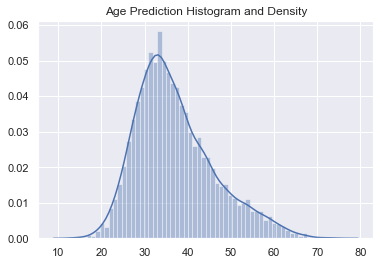

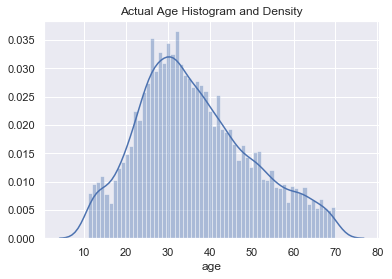

In [17]:
sns.distplot(age_preds, bins=60)
plt.title('Age Prediction Histogram and Density')
plt.show()

sns.distplot(test_set['age'], bins=60)
plt.title('Actual Age Histogram and Density')
plt.show()

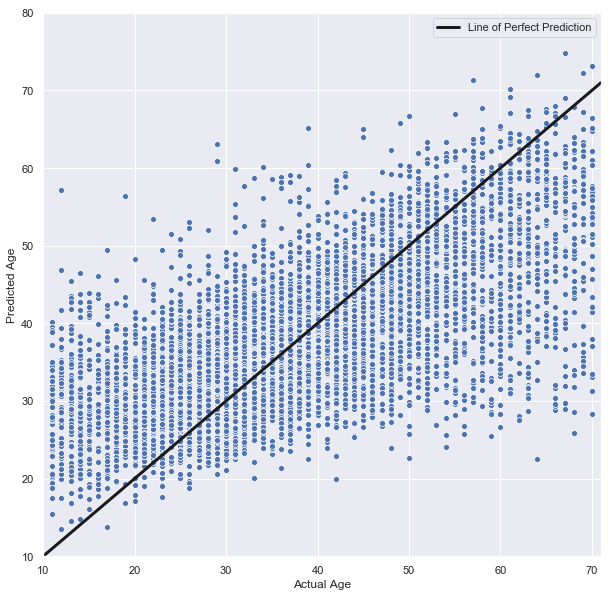

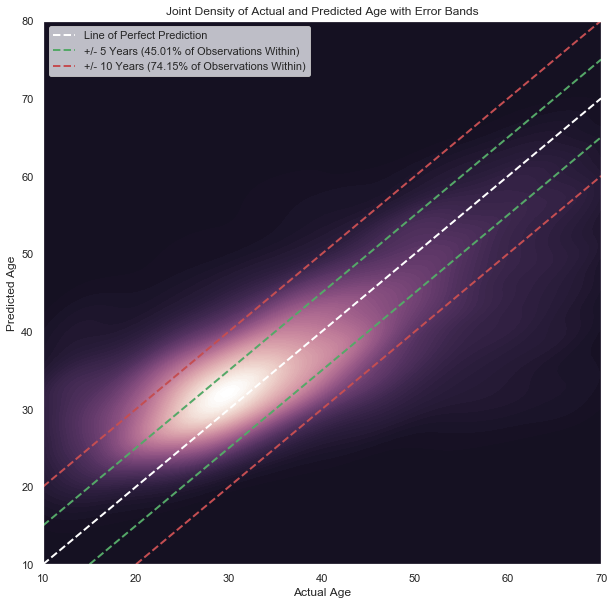

In [21]:
#Scatterplot
plt.figure(figsize=(10, 10))
plt.plot([10, 71], [10, 71], 'k', linewidth=3, label='Line of Perfect Prediction')
sns.scatterplot(test_set['age'].values, age_preds)
plt.xlim((10, 71))
plt.ylim((10, 80))
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()


#Density plot with error bands
within_5_years = (np.abs(age_preds - test_set['age'].values) <=5).mean()
within_5_years = np.round(100 * within_5_years, 2)
within_10_years = (np.abs(age_preds - test_set['age'].values) <=10).mean()
within_10_years = np.round(100 * within_10_years, 2)

plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0.075, light=1, reverse=True)
sns.kdeplot(test_set['age'].values, age_preds, cmap=cmap, n_levels=100, shade=True, 
            clip=[(10, 70), (10, 80)])
plt.plot([10, 70], [10, 70], 'w--', linewidth=2, 
         label='Line of Perfect Prediction')
plt.plot([10, 70], [15, 75], 'g--', linewidth=2, 
         label=f'+/- 5 Years ({within_5_years}% of Observations Within)')
plt.plot([15, 70], [10, 65], 'g--', linewidth=2)
plt.plot([10, 70], [20, 80], 'r--', linewidth=2, 
         label=f'+/- 10 Years ({within_10_years}% of Observations Within)')
plt.plot([20, 70], [10, 60], 'r--', linewidth=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend(loc='upper left')
plt.title('Joint Density of Actual and Predicted Age with Error Bands')
plt.show()